# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2024/2025 - Prof. Mark Carman
### Topic 8: Medical Question Answering
Dataset: 
* PubMedQA [link](https://huggingface.co/datasets/qiaojin/PubMedQA )

Reference paper:
* PubMedQA: A Dataset for Biomedical Research Question Answering [Link](https://arxiv.org/pdf/1909.06146)

## Group members:

* Ketrin Mehmeti
* Giulia Ghiazza
* Leonardo Giorgio Franco
* Edoardo Franco Mattei
* Alessandro Epifania

## Introduction
 
The PubMedQA dataset is an innovative resource for question answering (QA) in the biomedical field, created from abstracts of scientific articles available on PubMed. The main purpose of PubMedQA is to assess the reasoning and inference abilities of intelligent systems on natural language, particularly within the context of biomedical research texts, which often require the processing of quantitative content.

A typical instance in PubMedQA consists of the following components:

* A question, which can either be the original title of a research paper or derived from it. For example: "Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?"

* A context, which is the abstract corresponding to the question, excluding its conclusion.

* A long answer, represented by the conclusion of the abstract, which is expected to answer the research question.

* A short answer in the form of "yes," "no," or "maybe," summarizing the conclusion. In the provided example, the long answer is: "(Conclusion) Our study indicated that preoperative statin therapy seems to reduce AF development after CABG," while the short answer is "yes."

The PubMedQA dataset is divided into three subsets:

* PQA-L (Labeled): Contains 1k manually annotated instances with yes/no/maybe answers. These annotations were made in two modes: "reasoning-free," where the annotator had access to the long answer, and "reasoning-required," where the annotator could only rely on the context.

* PQA-U (Unlabeled): Consists of 61.2k unlabeled instances, made up of PubMed articles with question-form titles and structured abstracts.

* PQA-A (Artificial): Includes 211.3k artificially generated instances, where article titles in statement form are converted into questions, and yes/no answers are automatically assigned based on the presence or absence of negations in the original title.

A key feature of PubMedQA is that the contexts are generated to directly answer the questions, with both components written by the same authors, ensuring a strong relationship between the question and context. This makes PubMedQA an ideal benchmark for testing the scientific reasoning capabilities of machine reading comprehension models. The dataset often requires reasoning over the quantitative content found in abstracts to answer the questions.

## Preliminary initialization

qui inseriamo tutte ciò che bisogna scaricare per far runnare il notebook così non ci sono problemi

Eventualmente inseriamo il link della repo se ci sono file da scaricare

<mark style="background-color: white; color: black;">
pip install datasets  <br>
pip install pandas pyarrow <br>
pip install transformers <br>
pip install torch <br>
pip install wordcloud <br>
</mark>


## Libraries

The object dataset is a DatasetDict, which contains different splits like "train", "validation", and "test" if available.

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


### Loading the dataset: 

In [3]:
# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')               
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')    
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')  

In [4]:
print("Labeled dataset:", dataset_labeled)
print("Artificial dataset:", dataset_artificial)
print("Unlabeled dataset:", dataset_unlabeled)

# Notice that the feature final_decision is missing in the Unlabeled dataset, reflecting the fact 
# that these examples do not have a definitive yes/no/maybe label.

Labeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})
Artificial dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})
Unlabeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer'],
        num_rows: 61249
    })
})


In [5]:
print(dataset_labeled.keys())
print(dataset_artificial.keys())
print(dataset_unlabeled.keys())

dict_keys(['train'])
dict_keys(['train'])
dict_keys(['train'])


In [ ]:
# Convert the datasets to pandas DataFrames for easier manipulation
df_labeled = pd.DataFrame(dataset_labeled['train'])
df_unlabeled = pd.DataFrame(dataset_unlabeled['train'])
df_artificial = pd.DataFrame(dataset_artificial['train'])

## Preliminary analysis

In [7]:
# Check the data types of individual elements in each feature (question, context, long_answer)
# across the labeled, unlabeled, and artificial datasets. This is useful to verify that all elements 
# are strings before applying any text processing or tokenization functions, since functions from 
# libraries like Hugging Face's Transformers typically expect string inputs.

print(type(df_labeled['question'][0]))
print(type(df_labeled['context'][0]))
print(type(df_labeled['long_answer'][0]))

print(type(df_unlabeled['question'][0]))
print(type(df_unlabeled['context'][0]))
print(type(df_unlabeled['long_answer'][0]))

print(type(df_artificial['question'][0]))
print(type(df_artificial['context'][0]))
print(type(df_artificial['long_answer'][0]))

<class 'str'>
<class 'dict'>
<class 'str'>
<class 'str'>
<class 'dict'>
<class 'str'>
<class 'str'>
<class 'dict'>
<class 'str'>


## Description of the Expert-Annotated PQA-L Dataset

PQA-L is a key subset of the PubMedQA dataset, consisting of 1,000 manually labeled QA instances created for validation and testing. Each instance includes a question (usually a paper title), context (the abstract without the conclusion), a long answer (the conclusion), and a short yes/no/maybe label.

Two M.D. candidates annotated the data using two setups:

* Reasoning-free: the annotator saw the question, context, and long answer to assign the label directly.

* Reasoning-required: the annotator only saw the question and context, requiring inference without the conclusion.

Final labels were based on agreement between annotators, with disagreements resolved through discussion or instance removal. This dual-setup design highlights the task's difficulty: human accuracy drops from 90.4% (reasoning-free) to 78.0% (reasoning-required). The labels reflect the certainty or ambiguity of the article’s conclusion.

In [8]:
# Here we inspect the internal structure of the 'context' field in each dataset.
# Each 'context' entry is a dictionary containing multiple keys.
# In the labeled dataset, each context includes:
# - 'contexts': a list of textual context passages
# - 'labels': a list of associated labels
# - 'meshes': a list of medical subject headings
# - 'reasoning_required_pred': a list indicating whether reasoning is required (only in labeled)
# - 'reasoning_free_pred': a list indicating whether the question is reasoning-free (only in labeled)
# 
# In contrast, the unlabeled and artificial datasets contain only:
# - 'contexts', 'labels', and 'meshes'
# 
# This structural difference is important when preprocessing the data, 
# since some fields (e.g., 'reasoning_required_pred') may not be available across all datasets.


for key, value in df_labeled['context'][0].items():
    print(f"{key}: {type(value)}")

for key, value in df_unlabeled['context'][0].items():
    print(f"{key}: {type(value)}")

for key, value in df_artificial['context'][0].items():
    print(f"{key}: {type(value)}")

contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
reasoning_required_pred: <class 'list'>
reasoning_free_pred: <class 'list'>
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>


In [9]:
# This line calculates the average number of segments (i.e., separate strings) within the 'contexts' field of each instance.
# In the PubMedQA dataset, the abstract is split into multiple segments in the 'contexts' list to reflect its original sentence-level structure.
# This allows for more granular control when processing biomedical abstracts, especially for tasks that involve reasoning over specific parts of the text.
# Note: This does NOT measure the length in characters or words, only the number of abstract segments.

print("Average number of segments in contexts in the labeled dataset:", df_labeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the unlabeled dataset:", df_unlabeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the artificial dataset:", df_artificial['context'].apply(lambda x: len(x['contexts'])).mean())


Average number of segments in contexts in the labeled dataset: 3.358
Average number of segments in contexts in the unlabeled dataset: 3.3185031592352527
Average number of segments in contexts in the artificial dataset: 3.1005732028835276


In [10]:
# Here we join all the abstract segments (stored in the 'contexts' list) into a single string for each instance.
# This allows us to compute the average abstract length in terms of number of words, rather than number of segments.
# It's useful to understand how verbose or detailed the contexts are in natural language.

context_word_lengths_L = df_labeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the labeled dataset:", context_word_lengths_L.mean())
print("Standard deviation of words in abstract in the labeled dataset:", context_word_lengths_L.std())

context_word_lengths_U = df_unlabeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the unlabeled dataset:", context_word_lengths_U.mean())
print("Standard deviation of words in abstract in the unlabeled dataset:", context_word_lengths_U.std())

context_word_lengths_A = df_artificial['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the artificial dataset:", context_word_lengths_A.mean())
print("Standard deviation of words in abstract in the artificial dataset:", context_word_lengths_A.std())

# The average number of words in the abstract ('context') is very similar across the labeled, unlabeled, and artificial datasets,
# with means around 200 words. This consistency suggests that the datasets are well-aligned in terms of content length.
# Additionally, the standard deviations are comparable, indicating a similar spread and variability in abstract lengths.
# These observations support the assumption that the datasets are structurally balanced and comparable for downstream tasks.

Average number of words in abstract in the labeled dataset: 200.207
Standard deviation of words in abstract in the labeled dataset: 51.84642903038938
Average number of words in abstract in the unlabeled dataset: 198.7389018596222
Standard deviation of words in abstract in the unlabeled dataset: 56.65423030078211
Average number of words in abstract in the artificial dataset: 200.51420700623376
Standard deviation of words in abstract in the artificial dataset: 50.70859241655663


In [11]:
question_word_lengths_L = df_labeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the labeled dataset:", question_word_lengths_L.mean())
print("Standard deviation of words in question in the labeled dataset:", question_word_lengths_L.std())

question_word_lengths_U = df_unlabeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the unlabeled dataset:", question_word_lengths_U.mean())
print("Standard deviation of words in question in the unlabeled dataset:", question_word_lengths_U.std())

question_word_lengths_A = df_artificial['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the artificial dataset:", question_word_lengths_A.mean())
print("Standard deviation of words in question in the artificial dataset:", question_word_lengths_A.std())

# The average number of words in the 'question' field is slightly higher in the artificial dataset (~15.3 words)
# compared to the labeled (~12.9) and unlabeled (~13.3) datasets. Despite this difference, the standard deviations remain fairly close,
# indicating that the overall variability is consistent. This suggests that while artificial questions tend to be a bit longer,
# the distribution of their lengths is not drastically different, maintaining a reasonable alignment across datasets.

Average number of words in question in the labeled dataset: 12.913
Standard deviation of words in question in the labeled dataset: 4.100517680152744
Average number of words in question in the unlabeled dataset: 13.34506685823442
Standard deviation of words in question in the unlabeled dataset: 4.567043839545208
Average number of words in question in the artificial dataset: 15.344096862294043
Standard deviation of words in question in the artificial dataset: 3.898447348860483


In [12]:
long_answ_lengths_L = df_labeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the labeled dataset:", long_answ_lengths_L.mean())
print("Standard deviation of long_answer in the labeled dataset:", long_answ_lengths_L.std())

long_answ_lengths_U = df_unlabeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the unlabeled dataset:", long_answ_lengths_U.mean())
print("Standard deviation of long_answer in the unlabeled dataset:", long_answ_lengths_U.std())

long_answ_lengths_A = df_artificial['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the artificial dataset:", long_answ_lengths_A.mean())
print("Standard deviation of long_answer in the artificial dataset:", long_answ_lengths_A.std())

# The average number of words in the 'long_answer' field is relatively similar across the three datasets,
# ranging from approximately 37.6 to 42.0 words. The standard deviations are also comparable,
# suggesting that the variability in long answer lengths is consistent. Overall, there are no significant discrepancies in length distribution.

Average number of words in long_answer in the labeled dataset: 39.66
Standard deviation of long_answer in the labeled dataset: 17.209432430053138
Average number of words in long_answer in the unlabeled dataset: 42.02336364675342
Standard deviation of long_answer in the unlabeled dataset: 19.817240489404714
Average number of words in long_answer in the artificial dataset: 37.593660215175916
Standard deviation of long_answer in the artificial dataset: 18.49701353631026


In [13]:
# Count of 'final_decision' labels in Labeled and Artificial datasets

print(f"Occurrences of 'yes' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['no']}")
print(f"Occurrences of 'maybe' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['maybe']}")

print(f"Occurrences of 'yes' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['no']}")

Occurrences of 'yes' as the final decision in the Labeled dataset: 552
Occurrences of 'no' as the final decision in the Labeled dataset: 338
Occurrences of 'maybe' as the final decision in the Labeled dataset: 110
Occurrences of 'yes' as the final decision in the Artificial dataset: 196144
Occurrences of 'no' as the final decision in the Artificial dataset: 15125


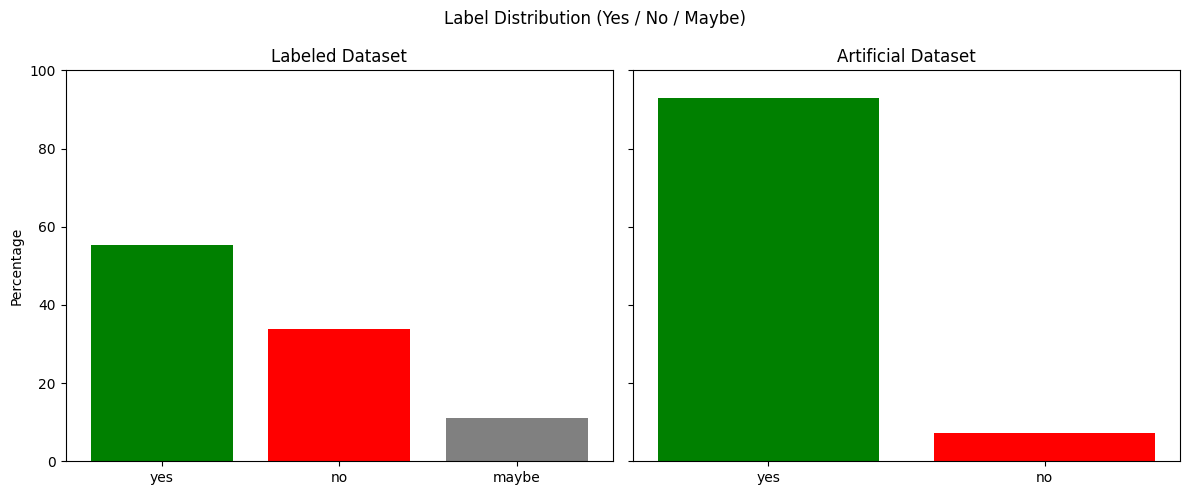

In [14]:
# Plot the percentage distribution of final decision labels ('yes', 'no', 'maybe') 
# for both the labeled and artificial datasets using side-by-side bar charts.

# Create subplots with shared y-axis to ensure the same scale across both bar plots.
# This makes it easier to visually compare the distribution of 'yes', 'no', and 'maybe' labels
# between the labeled and artificial datasets.

# Count label frequencies
labeled_counts = df_labeled['final_decision'].value_counts(normalize=True) * 100  
artificial_counts = df_artificial['final_decision'].value_counts(normalize=True) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot labeled dataset
axes[0].bar(labeled_counts.index, labeled_counts.values, color=['green', 'red', 'gray'])
axes[0].set_title("Labeled Dataset")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 100)

# Plot artificial dataset
axes[1].bar(artificial_counts.index, artificial_counts.values, color=['green', 'red', 'gray'])
axes[1].set_title("Artificial Dataset")
axes[1].set_ylim(0, 100)

plt.suptitle("Label Distribution (Yes / No / Maybe)")
plt.tight_layout()
plt.show()


In [15]:
# Download NLTK stopwords and tokenizer resources.
# Define a function to build a vocabulary counter from a list of texts:
# it lowercases the text, filters out stopwords and non-alphabetic tokens,
# and counts the frequency of each remaining word.

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def get_vocab(texts):
    vocab_counter = Counter()
    for text in texts:
        if isinstance(text, str):
            words = text.lower().split()
            filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
            vocab_counter.update(filtered_words)
    return vocab_counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Labeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_L = get_vocab(df_labeled['question'])
context_vocab_L = get_vocab([" ".join(ctx['contexts']) for ctx in df_labeled['context']])
long_answer_vocab_L = get_vocab(df_labeled['long_answer'])

print("Top 10 question words:", question_vocab_L.most_common(10))
print("Top 10 context words:", context_vocab_L.most_common(10))
print("Top 10 long_answer words:", long_answer_vocab_L.most_common(10))

print("Vocabulary size in questions:", len(question_vocab_L))
print("Vocabulary size in context:", len(context_vocab_L))
print("Vocabulary size in long_answer:", len(long_answer_vocab_L))

Top 10 question words: [('patients', 107), ('predict', 54), ('risk', 53), ('affect', 42), ('cancer', 40), ('care', 38), ('treatment', 36), ('improve', 33), ('influence', 32), ('clinical', 29)]
Top 10 context words: [('patients', 2044), ('study', 736), ('group', 555), ('compared', 423), ('significantly', 394), ('significant', 383), ('using', 376), ('mean', 326), ('whether', 321), ('data', 320)]
Top 10 long_answer words: [('patients', 293), ('may', 256), ('risk', 135), ('study', 121), ('results', 120), ('associated', 109), ('clinical', 99), ('treatment', 87), ('suggest', 80), ('significant', 80)]
Vocabulary size in questions: 3034
Vocabulary size in context: 10592
Vocabulary size in long_answer: 5457


In [17]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Unlabeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_U = get_vocab(df_unlabeled['question'])
context_vocab_U = get_vocab([" ".join(ctx['contexts']) for ctx in df_unlabeled['context']])
long_answer_vocab_U = get_vocab(df_unlabeled['long_answer'])

print("Top 10 question words:", question_vocab_U.most_common(10))
print("Top 10 context words:", context_vocab_U.most_common(10))
print("Top 10 long_answer words:", long_answer_vocab_U.most_common(10))

print("Vocabulary size in questions:", len(question_vocab_U))
print("Vocabulary size in context:", len(context_vocab_U))
print("Vocabulary size in long_answer:", len(long_answer_vocab_U))

Top 10 question words: [('patients', 6019), ('risk', 3126), ('treatment', 2193), ('cancer', 2157), ('predict', 2031), ('affect', 1987), ('associated', 1864), ('health', 1827), ('clinical', 1776), ('improve', 1743)]
Top 10 context words: [('patients', 124962), ('study', 41674), ('group', 35371), ('compared', 25634), ('using', 23691), ('significant', 23029), ('significantly', 21726), ('two', 20180), ('risk', 19519), ('mean', 19366)]
Top 10 long_answer words: [('patients', 20522), ('may', 15891), ('risk', 8286), ('study', 7202), ('results', 7165), ('associated', 6965), ('clinical', 6044), ('treatment', 5535), ('use', 5421), ('suggest', 5039)]
Vocabulary size in questions: 25370
Vocabulary size in context: 71989
Vocabulary size in long_answer: 41880


In [18]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Artificial dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_A = get_vocab(df_artificial['question'])
context_vocab_A = get_vocab([" ".join(ctx['contexts']) for ctx in df_artificial['context']])
long_answer_vocab_A = get_vocab(df_artificial['long_answer'])

print("Top 10 question words:", question_vocab_A.most_common(10))
print("Top 10 context words:", context_vocab_A.most_common(10))
print("Top 10 long_answer words:", long_answer_vocab_A.most_common(10))

print("Vocabulary size in questions:", len(question_vocab_A))
print("Vocabulary size in context:", len(context_vocab_A))
print("Vocabulary size in long_answer:", len(long_answer_vocab_A))

Top 10 question words: [('associated', 29304), ('patients', 20726), ('cell', 12270), ('human', 12033), ('expression', 10917), ('cells', 10531), ('cancer', 9816), ('predict', 8543), ('risk', 8408), ('factor', 7703)]
Top 10 context words: [('patients', 272161), ('expression', 119844), ('study', 109274), ('significantly', 107742), ('cells', 105349), ('p', 97650), ('cell', 95718), ('levels', 91193), ('compared', 90459), ('group', 88096)]
Top 10 long_answer words: [('may', 57736), ('patients', 43975), ('results', 33230), ('associated', 32046), ('suggest', 26025), ('study', 21367), ('risk', 20590), ('expression', 18244), ('increased', 18079), ('data', 17988)]
Vocabulary size in questions: 51795
Vocabulary size in context: 134389
Vocabulary size in long_answer: 73385


In [19]:
# Now we compute the total vocabulary across all three datasets for the 'question' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_question = (
    question_vocab_L + question_vocab_U + question_vocab_A
)

# Print the 20 most common words in the combined vocabulary of the question feature, along with the total vocabulary size.
print("\nTop 20 most common words in the entire corpus:", total_vocab_question.most_common(20))
print("Total vocabulary size across all datasets:", len(total_vocab_question))



Top 20 most common words in the entire corpus: [('associated', 31192), ('patients', 26852), ('cell', 13270), ('human', 12553), ('cancer', 12013), ('risk', 11587), ('expression', 11201), ('cells', 10773), ('predict', 10628), ('factor', 8845), ('improve', 8724), ('disease', 7812), ('treatment', 7611), ('acute', 7538), ('gene', 7436), ('increased', 7065), ('protein', 6831), ('chronic', 6649), ('growth', 6574), ('levels', 6505)]
Total vocabulary size across all datasets: 57494


In [20]:
# Now we compute the total vocabulary across all three datasets for the 'context' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_context = (
    context_vocab_L + context_vocab_U + context_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the context feature, along with the total vocabulary size.
print("\nTop 20 most common words in the entire corpus:", total_vocab_context.most_common(20))
print("Total vocabulary size across all datasets:", len(total_vocab_context))



Top 20 most common words in the entire corpus: [('patients', 399167), ('study', 151684), ('significantly', 129862), ('group', 124022), ('expression', 122463), ('compared', 116516), ('p', 115027), ('using', 109717), ('cells', 108365), ('associated', 105714), ('levels', 102699), ('cell', 100220), ('increased', 99397), ('significant', 87683), ('higher', 76351), ('treatment', 74767), ('used', 73666), ('risk', 71943), ('also', 69079), ('analysis', 66401)]
Total vocabulary size across all datasets: 153496


In [21]:
# Now we compute the total vocabulary across all three datasets for the 'long_answer' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_long_answer = (
    long_answer_vocab_L + long_answer_vocab_U + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the long_answer feature, along with the total vocabulary size.
print("\nTop 20 most common words in the entire corpus:", total_vocab_long_answer.most_common(20))
print("Total vocabulary size across all datasets:", len(total_vocab_long_answer))


Top 20 most common words in the entire corpus: [('may', 73883), ('patients', 64790), ('results', 40515), ('associated', 39120), ('suggest', 31144), ('risk', 29011), ('study', 28690), ('treatment', 22527), ('increased', 22177), ('findings', 22064), ('data', 21750), ('clinical', 20020), ('expression', 18819), ('role', 18251), ('could', 16999), ('levels', 15663), ('high', 15270), ('cell', 15262), ('effect', 14883), ('cells', 14822)]
Total vocabulary size across all datasets: 84012


In [22]:
# Now we compute the total vocabulary across all three datasets for all features combined.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab = (
    question_vocab_L + context_vocab_L + long_answer_vocab_L +
    question_vocab_U + context_vocab_U + long_answer_vocab_U +
    question_vocab_A + context_vocab_A + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary across all features, along with the total vocabulary size.
print("\nTop 20 most common words in the entire corpus:", total_vocab.most_common(20))
print("Total vocabulary size across all datasets:", len(total_vocab))



Top 20 most common words in the entire corpus: [('patients', 490809), ('study', 183171), ('associated', 176026), ('expression', 152483), ('significantly', 144070), ('cells', 133960), ('cell', 128752), ('increased', 128639), ('group', 128636), ('compared', 127461), ('levels', 124867), ('using', 119313), ('p', 115767), ('risk', 112541), ('may', 110618), ('treatment', 104905), ('significant', 102088), ('higher', 90998), ('clinical', 88075), ('cancer', 85056)]
Total vocabulary size across all datasets: 163610


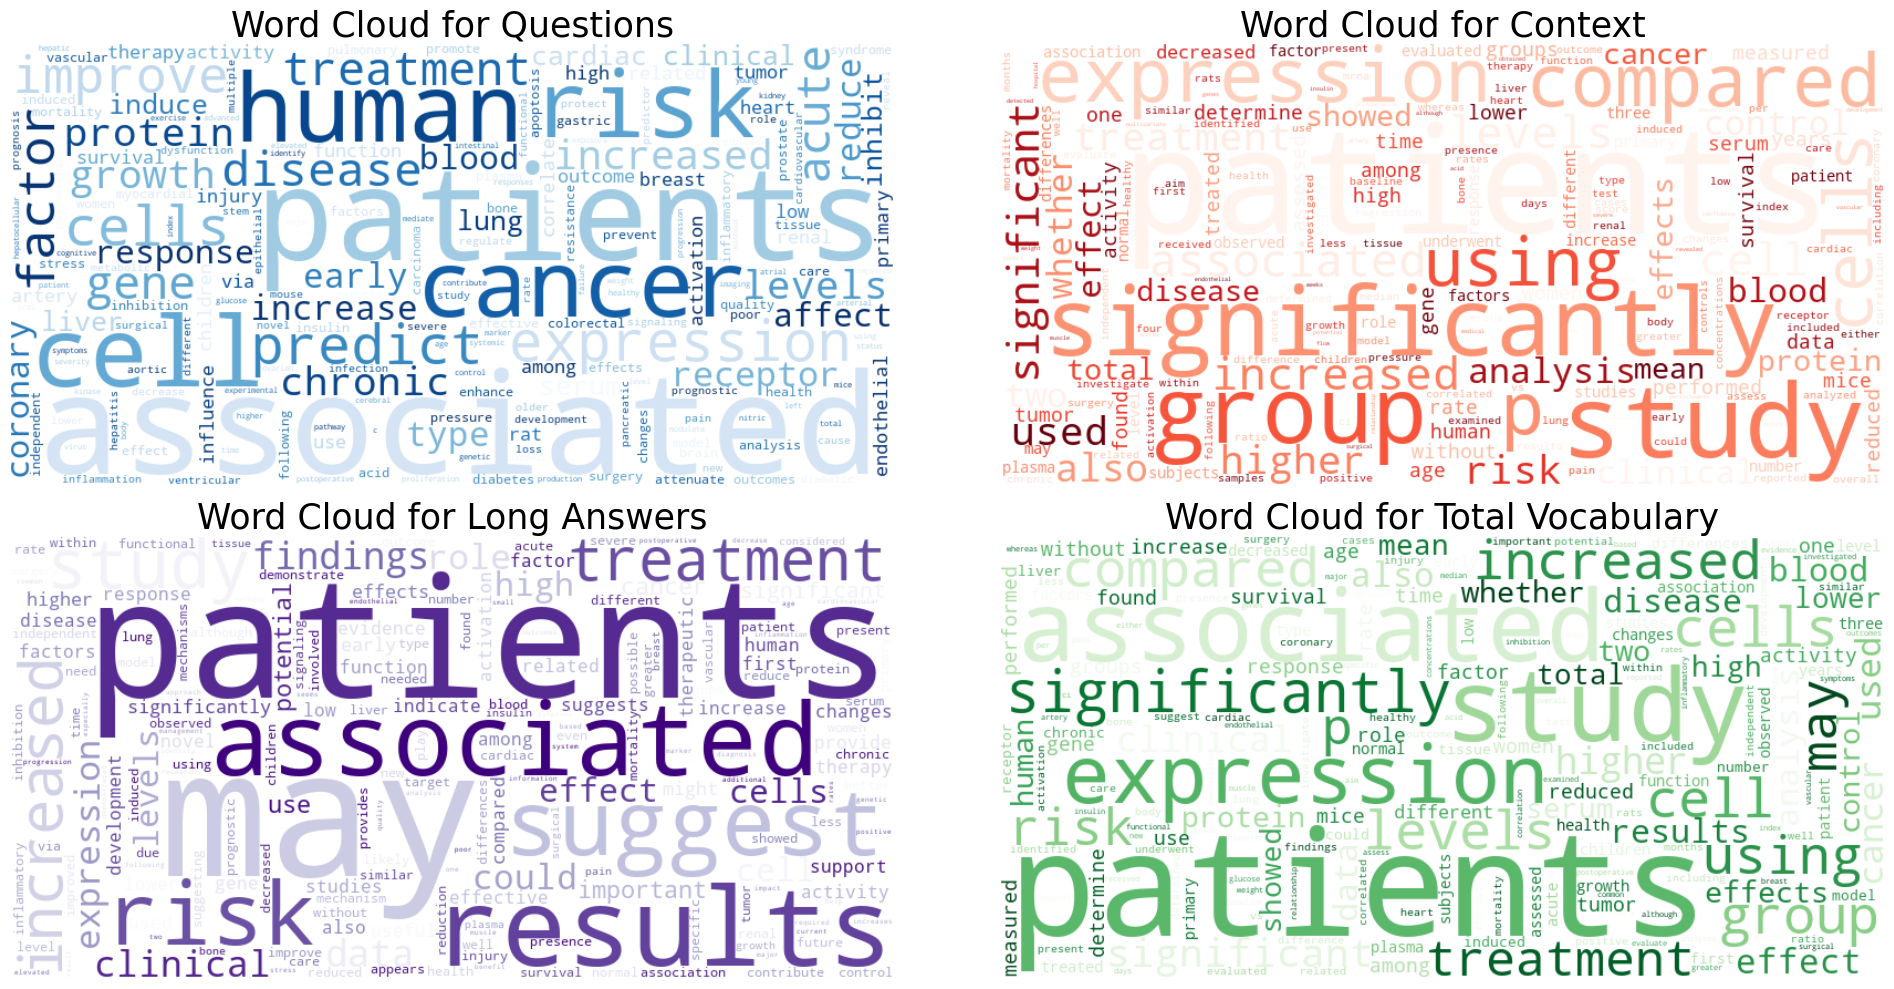

In [23]:
# Now we generate word clouds for the vocabularies of the three features: 'question', 'context', and 'long_answer' and for the total vocabulary across all datasets.
# A word cloud is a visual representation of word frequency, where more frequent words appear larger.
# The function 'generate_wordcloud' takes a vocabulary counter (a dictionary of word frequencies) and a title for the plot.

vocabs = [
    (total_vocab_question, "Questions", "Blues"),
    (total_vocab_context, "Context", "Reds"),
    (total_vocab_long_answer, "Long Answers", "Purples"),
    (total_vocab, "Total Vocabulary", "Greens")  # Aggiungi questo solo se hai total_vocab_total
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, (vocab, title, colormap) in zip(axes.flat, vocabs):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(vocab)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for {title}", fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Classification task
### Why we applied PCA and visualized the TF-IDF vectors

To better understand whether the automatically generated (artificial) dataset is suitable for training a classifier to be evaluated on the manually labeled dataset, we applied Principal Component Analysis (PCA) to reduce the high-dimensional TF-IDF vectors into two dimensions. We then plotted the projections for both the *questions* and the *long answers*.

This visual inspection allows us to assess:
- How well the artificial and labeled data overlap in the feature space.
- Whether the classifier trained on artificial data could potentially generalize to labeled data.
- Whether the *question*, the *long answer*, or their combination contains more discriminative information.
  
The artificial dataset was generated using a heuristic approach, where "yes" and "no" labels were automatically assigned based on the presence or absence of negation in the question. This means that the labels in the artificial data are **noisy** and might not perfectly represent the true ground truth, as they were not manually assigned by experts but inferred from the structure of the questions. 

Despite this, the artificial data is a valuable resource for **pre-training** the model, as it provides a large volume of labeled examples. However, we must carefully validate the model on the manually labeled data (ground truth) to assess whether it can handle noisy labels and generalize to real-world scenarios. 

This exploratory step is crucial when using **noisily-labeled data** for training and a small amount of **clean labeled data** for validation. Visualizing the data in lower dimensions helps to understand whether it is feasible to train a robust model and what features (questions, long answers, or both) contribute the most to successful classification.


In [24]:
# Sample 10k examples from each class ("yes" and "no") in the artificial dataset to balance the class distribution
no_sample = df_artificial[df_artificial['final_decision'] == 'no'].sample(n=10000, random_state=42)
yes_sample = df_artificial[df_artificial['final_decision'] == 'yes'].sample(n=10000, random_state=42)

# Combine and shuffle the two samples to form a balanced artificial dataset
df_artificial_sampled = pd.concat([yes_sample, no_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Add a 'source' column to each dataset to keep track of origin (Artificial vs. Labeled)
# This can later help in evaluating model robustness across domains or training cross-source models
df_artificial_sampled['source'] = 'Artificial'
df_labeled['source'] = 'Labeled'

# Drop examples in the labeled dataset where the label is "maybe"
# Since "maybe" cannot be predicted by a binary classifier trained on "yes"/"no"
df_labeled_clean = df_labeled[df_labeled['final_decision'].isin(['yes', 'no'])].copy()

# Merge the two datasets (balanced artificial + cleaned labeled) keeping only relevant text fields and source info
df_combined = pd.concat([
    df_artificial_sampled[['question', 'long_answer','final_decision', 'source']],
    df_labeled_clean[['question', 'long_answer','final_decision', 'source']]
])

# TF-IDF vectorization of questions and long answers separately
# These matrices can be used independently or concatenated for downstream classifiers
vectorizer = TfidfVectorizer(max_features=50000)
X_Q_tfidf = vectorizer.fit_transform(df_combined['question'])      # TF-IDF features from questions
X_LA_tfidf = vectorizer.fit_transform(df_combined['long_answer'])  # TF-IDF features from long answers


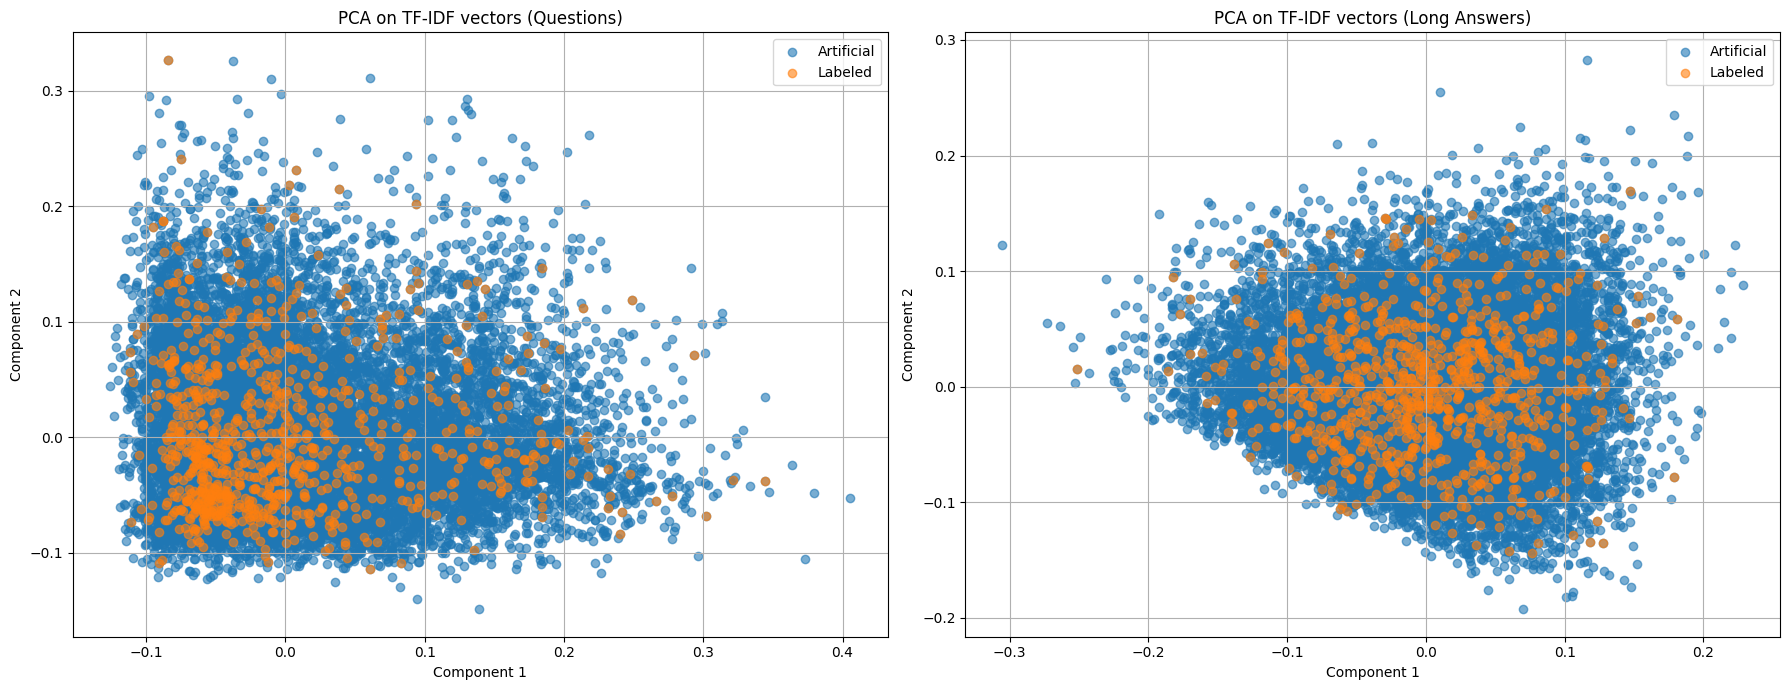

In [25]:
# Apply PCA to the questions
pca_q = PCA(n_components=2)
X_Q_reduced = pca_q.fit_transform(X_Q_tfidf.toarray())  # Reduce the dimensionality of the question vectors

# Apply PCA to the long answers
pca_la = PCA(n_components=2)
X_LA_reduced = pca_la.fit_transform(X_LA_tfidf.toarray())  # Reduce the dimensionality of the long answer vectors

# Create a figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot for questions
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[0].scatter(
        X_Q_reduced[subset.index, 0],  # First principal component of the questions
        X_Q_reduced[subset.index, 1],  # Second principal component of the questions
        label=source,  # Label the points by source (Artificial or Labeled)
        alpha=0.6  # Set transparency for better visualization
    )
axes[0].set_title("PCA on TF-IDF vectors (Questions)")  
axes[0].set_xlabel("Component 1")  
axes[0].set_ylabel("Component 2")  
axes[0].legend()  
axes[0].grid(True) 

# Plot for long answers
for source in df_combined['source'].unique():  # Loop through each unique source (Artificial and Labeled)
    subset = df_combined[df_combined['source'] == source]  # Subset the data based on the source
    axes[1].scatter(
        X_LA_reduced[subset.index, 0],  # First principal component of the long answers
        X_LA_reduced[subset.index, 1],  # Second principal component of the long answers
        label=source,  
        alpha=0.6  
    )
    
axes[1].set_title("PCA on TF-IDF vectors (Long Answers)")  
axes[1].set_xlabel("Component 1")  
axes[1].set_ylabel("Component 2")  
axes[1].legend()  
axes[1].grid(True)  

plt.tight_layout()
plt.show()


In [ ]:
# We build separate TF-IDF vectorizers for the 'question' and 'long_answer' fields.
# First, we fit each vectorizer on the artificial (larger and noisier) dataset to extract the vocabulary and term weights.
# Then, we use the same fitted vectorizers to transform the labeled clean dataset, ensuring that both datasets are projected
# into the same feature space (i.e., with the same number and order of features).
# This is crucial because we want to train classification models on the artificial dataset (X_Q_tfidf_A and X_LA_tfidf_A),
# and then evaluate them on the clean labeled dataset (X_Q_tfidf_L and X_LA_tfidf_L), which serves as a reliable benchmark.
# Finally, we extract the corresponding labels for supervised learning (y_A for training, y_L for validation).

# We use TfidfVectorizer to convert the text data into TF-IDF features.

# Questions
vectorizer_q = TfidfVectorizer(max_features=50000)
X_Q_tfidf_A = vectorizer_q.fit_transform(df_artificial_sampled['question'])
X_Q_tfidf_L = vectorizer_q.transform(df_labeled_clean['question'])

# Long Answers
vectorizer_la = TfidfVectorizer(max_features=50000)
X_LA_tfidf_A = vectorizer_la.fit_transform(df_artificial_sampled['long_answer'])
X_LA_tfidf_L = vectorizer_la.transform(df_labeled_clean['long_answer'])

# Label
y_A = df_artificial_sampled['final_decision']
y_L = df_labeled_clean['final_decision']


In [ ]:
# The classification results were obtained by providing the classifier with only the questions (no long answers).
# Results on the labeled dataset are as follows:
# - SVM - Accuracy: 0.5326
# - Logistic Regression - Accuracy: 0.5281
# - Random Forest - Accuracy: 0.4472
# 
# The best model is SVM with an accuracy of 53.26%. However, the overall accuracy is relatively low,
# which could be due to the limited information provided by only using the questions without considering the long answers.
# This suggests that incorporating more contextual information (e.g., long answers) might improve the model's performance.

# We will train and evaluate several classifiers on the artificial dataset (X_Q_tfidf_A, y_A) and validate them on the labeled dataset (X_Q_tfidf_L, y_L).
# The classifiers include SVM, Logistic Regression, Random Forest.
models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_Q_tfidf_A, y_A)  
    y_pred = model.predict(X_Q_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_Q_tfidf_L)))


SVM - Accuracy on Labeled dataset: 0.5326
Logistic Regression - Accuracy on Labeled dataset: 0.5281
Random Forest - Accuracy on Labeled dataset: 0.4472

Best model on Labeled dataset: SVM with accuracy: 0.5326

Classification report:
              precision    recall  f1-score   support

          no       0.43      0.74      0.55       338
         yes       0.72      0.40      0.52       552

    accuracy                           0.53       890
   macro avg       0.58      0.57      0.53       890
weighted avg       0.61      0.53      0.53       890



In [ ]:
# In this cell, we train and evaluate multiple classifiers to identify the best-performing model
# when using only the 'long_answer' text as input features instead of the 'question' field.
# We vectorize the 'long_answer' using a TF-IDF representation, train on the artificial labeled dataset,
# and evaluate model performance on the clean labeled dataset. This setup allows us to assess
# whether the additional contextual information present in long answers improves classification accuracy.

# Results summary:
# When using the 'long_answer' field as input features (TF-IDF vectorized), all classifiers significantly outperform 
# those trained only on the 'question' field. The best model in this case is Logistic Regression, 
# achieving an accuracy of 77.64% on the labeled dataset.
# The classification report shows a strong performance for both classes, especially for the 'yes' class 
# with precision 0.83 and recall 0.80. These results suggest that long answers contain richer and more informative 
# content, allowing the model to better capture patterns associated with the final decision.

models = {
    'SVM': SVC(C=1, kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(C=1, random_state=42, solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5),
}

best_model = None
best_model_name = ""
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_LA_tfidf_A, y_A)  
    y_pred = model.predict(X_LA_tfidf_L)  
    acc = accuracy_score(y_L, y_pred)
    print(f"{name} - Accuracy on Labeled dataset: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

# Print the best model and its accuracy
print(f"\nBest model on Labeled dataset: {best_model_name} with accuracy: {best_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_L, best_model.predict(X_LA_tfidf_L)))

SVM - Accuracy on Labeled dataset: 0.7753
Logistic Regression - Accuracy on Labeled dataset: 0.7764
Random Forest - Accuracy on Labeled dataset: 0.7506

Best model on Labeled dataset: Logistic Regression with accuracy: 0.7764

Classification report:
              precision    recall  f1-score   support

          no       0.69      0.74      0.72       338
         yes       0.83      0.80      0.82       552

    accuracy                           0.78       890
   macro avg       0.76      0.77      0.77       890
weighted avg       0.78      0.78      0.78       890

